The purpose of this notebook is to find all of the possible decay chains based off of the data in livechart. 

In [1]:
using Unitful #https://painterqubits.github.io/Unitful.jl/stable/
#quantity * @u_str("unit abbreviation") 
using Symbolics #https://symbolics.juliasymbolics.org/dev/
#cite https://doi.org/10.48550/arXiv.2105.03949
using Latexify
using Test
#1 * @u_str("mA") is 1 milliamp
using CSV, DataFrames
#using Plots
using PlotlyJS
using Printf
using SymPy #https://docs.juliahub.com/SymPy/ 
using PDFIO
using Unzip
using Interpolations
using Downloads
using Graphs, GraphRecipes
using GraphPlot
#plotlyjs()
data_dir = ("C:\\Cross-Section-Data\\")
cross_section_dir = data_dir
parent_dir = "C:\\Users\\engin\\Documents\\GitHub\\Energy\\"
endf8_decay_dir = cross_section_dir * "ENDF_Libraries-2\\ENDF-B-VIII.0\\decay\\"
jeff33_decay_dir = cross_section_dir * "ENDF_Libraries-2\\JEFF-3.3\\decay\\"
jendl5_decay_dir = cross_section_dir * "jendl5-dec_upd5\\"

WebIO._IJuliaInit()

"C:\\Cross-Section-Data\\jendl5-dec_upd5\\"

Now I will find the average decay energies for each nuclide. For the datasets I am using, the average decay energies are all given in keV. 

In [2]:
function get_mass_name(nuclide)
    index = 1
    while (tryparse(Int64, string(nuclide[index])) != nothing && index <= length(nuclide))
        index += 1
    end
    mass = tryparse(Int64, nuclide[1:index-1])
    name =  nuclide[index:end]
    name_1 = uppercase(name[1])
    if (length(name) > 1)
        name = name_1 * name[2]
    else 
      name = name_1
    end
    return mass, name
end
element_symbols = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", 
"Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca", "Sc", "Ti", "V", 
"Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", 
"Kr", "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", 
"Cd", "In", "Sn", "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", 
"Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", 
"Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", 
"Po", "At", "Rn", "Fr", "Ra", "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", 
"Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", 
"Hs", "Mt", "Ds", "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"];

Rename files in directory to be easier to parse by removing zero-padding.

In [3]:
function unzero_pad(num_str) 
    if (num_str == '0')
        return num_str
    end
    i = 1
    while i < length(num_str) && num_str[i] == '0'
        i += 1
    end
    return num_str[i : end]
end
function rename_files_in_dir(dir, cutoff_index)
    for f in readdir(dir)
        if tryparse(Int64, string(f[1])) == nothing
            mv(dir * f, dir * f[cutoff_index:end])
        end
        if f != join(unzero_pad.(split(f, "-")), "-")
            mv(dir * f, dir * join(unzero_pad.(split(f, "-")), "-"))
        end
    end
end
rename_files_in_dir(endf8_decay_dir, 12)
rename_files_in_dir(jeff33_decay_dir, 12)
rename_files_in_dir(jendl5_decay_dir, 4)

In [4]:
function get_decay_energy_from_file(file_as_arr, search_string)
    line = [l for l in file_as_arr if length(l) > length(search_string)
             && occursin(search_string, l)]
    if (length(line) > 0)
        line = String(line[1])
        line = join(split(line, search_string, keepempty = false))
        return tryparse(Float64, join(split(line, " ", keepempty = false)[1]))
    else 
        return "Energy not found"
    end
end

get_decay_energy_from_file (generic function with 1 method)

This dictionary stores what strings to look to for in the datasets to find the average energy for each decay type, and for each directory. 

In [5]:
dir_search_string_dict = Dict([
    jeff33_decay_dir => Dict(["alpha" => "ALPHA ENERGY                   =",
    "beta-minus" => "MEAN BETA- ENERGY              =","gamma" => "MEAN GAMMA ENERGY              =", 
    "x-ray" => "MEAN X-RAY ENERGY              =", "auger" => "MEAN AUGER ELECTRON ENERGY     ="
    ]),

    endf8_decay_dir => Dict(["alpha" => "Mean Alpha Energy:", 
    "beta-minus" => "Mean B- Energy:", "beta-plus" => "Mean B+ Energy:",
    "gamma" => "Mean Gamma Energy:", "auger" => "Mean CE+Auger Energy:",
    "neutron" => "Mean Neutron Energy:", "proton" => "Mean Neutron Energy:",
    "half life" => "Parent half-life:"]),

    jendl5_decay_dir => Dict(["alpha" => "Mean Alpha Energy",
    "beta-minus" => "Mean B- Energy", "gamma" => "Mean Gamma Energy",
    "neutron" => "Mean Neutron Energy", "proton" => "Mean Proton Energy",
    "auger" => "Mean CE+Auger Energy", 
    "beta-plus and electron capture" => "Mean B+/EC Energy"])  
])

Dict{String, Dict{String, String}} with 3 entries:
  "C:\\Cross-Section-Data\… => Dict("auger"=>"Mean CE+Auger Energy", "beta-plus…
  "C:\\Cross-Section-Data\… => Dict("auger"=>"Mean CE+Auger Energy:", "proton"=…
  "C:\\Cross-Section-Data\… => Dict("auger"=>"MEAN AUGER ELECTRON ENERGY     ="…

Note that based on the documentation for the livechart API, the decay type denoted "B+" also includes electron capture. 

Source: 

https://www-nds.iaea.org/relnsd/vcharthtml/api_v0_guide.html#apirad_type 

In [6]:
joules_per_keV = Rational(uconvert(@u_str("J"), 1 * @u_str("keV")) / @u_str("J"))
joules_per_MeV = 1000 * joules_per_keV
h = 6.62607015 * 10.0^(-34) / (2 * pi)
half_life_sec(gamma) = h / (joules_per_MeV * gamma)
half_life_sec(4.6)

1.4308955585889278e-22

This function is meant for particularly short half lives reported in terms of the decay width. 

In [7]:
function find_decay_info(nuclide, info, dir)
    a, el = get_mass_name(nuclide)
    el = string(el)
    z = [i for i in 1:length(element_symbols) if element_symbols[i] == el][1]
    file_name = string(z) * "-" * el * "-" * string(a) * ".dat"
    if !(file_name in readdir(dir))
        return "insufficient data"
    end
    file_path = dir * file_name
    file_as_array = split(open(f->read(f, String), file_path), "\n")
    search_string = dir_search_string_dict[dir][info]
    return get_decay_energy_from_file(file_as_array, search_string)
end

find_decay_info (generic function with 1 method)

In [8]:
small_decay_time(nuclide, dir) = string(half_life_sec(find_decay_info(nuclide, "half life", dir)))   
small_decay_time("4H", endf8_decay_dir)

"1.4308955585889278e-22"

In [9]:
function find_avg_decay_energy(nuclide, decay_type, dir)
    a, el = get_mass_name(nuclide)
    el = string(el)
    z = [i for i in 1:length(element_symbols) if element_symbols[i] == el][1]
    file_name = string(z) * "-" * el * "-" * string(a) * ".dat"
    if ! (file_name in readdir(dir))
        return "Energy not found"
    end
    file_path = dir * file_name
    file_as_array = split(open(f->read(f, String), file_path), "\n")
    search_string = dir_search_string_dict[dir][decay_type]
    return get_decay_energy_from_file(file_as_array, search_string)
end
dir_list = keys(dir_search_string_dict)
function find_avg_decay_energy(nuclide, decay_type)
    if decay_type == "electron capture"
        decay_type = "beta-plus and electron capture"
    end
    for dir in dir_list
        if decay_type in keys(dir_search_string_dict[dir])
            energy = find_avg_decay_energy(nuclide, decay_type, dir)
            if energy != "Energy not found"
                return energy
            end
        end
    end
    return "Energy not found"
end

find_avg_decay_energy (generic function with 2 methods)

Now for some examples. Again, all average decay energies are given in keV. 

In [10]:
out = find_avg_decay_energy("238U", "alpha", jeff33_decay_dir)

4187.0737

In [11]:
out = find_avg_decay_energy("3H", "beta-minus", jendl5_decay_dir)

5.69

In [12]:
avg_decay_energy = find_avg_decay_energy("8Be", "alpha", jendl5_decay_dir)

"Energy not found"

In [13]:
avg_decay_energy = find_avg_decay_energy("8Be", "alpha", jendl5_decay_dir)
if avg_decay_energy == "Energy not found"
    avg_decay_energy = find_avg_decay_energy("8Be", "alpha", jeff33_decay_dir)
end

45.95

In [14]:
find_avg_decay_energy("238U", "alpha", endf8_decay_dir)

4187.0

In [15]:
live_chart_file_name = "all_livechart_decays_and_emissions.csv"
all_live_chart_data = CSV.read(parent_dir * "ImportedData\\" * live_chart_file_name,
                        DataFrame, stringtype = String)[:,2:end]

,z,n,symbol,radius,unc_r,abundance,abundance_unc,energy_shift
,Int64,Int64,String,String,Float64?,String,String?,String?
1,0,1,Nn,-0.1149,0.0027,,missing,
2,0,4,N,,missing,,missing,
3,0,6,N,,missing,,missing,
4,1,0,H,0.8783,0.0086,99.9855,78,
5,1,1,H,2.1421,0.0088,0.0145,78,
6,1,2,H,1.7591,0.0363,,missing,
7,1,3,H,,missing,,missing,
8,1,4,H,,missing,,missing,
9,1,5,H,,missing,,missing,


In [16]:
all_live_chart_data[!, "nuclide"] = [string(all_live_chart_data[row, "z"] + 
                        all_live_chart_data[row, "n"]) * all_live_chart_data[row, "symbol"]
                        for row in 1:size(all_live_chart_data)[1]]
livechart_nuclides = unique(all_live_chart_data[!, "nuclide"])

3367-element Vector{String}:
 "1Nn"
 "4N"
 "6N"
 "1H"
 "2H"
 "3H"
 "4H"
 "5H"
 "6H"
 "7H"
 "3He"
 "4He"
 "5He"
 ⋮
 "287Mc"
 "288Mc"
 "289Mc"
 "290Mc"
 "290Lv"
 "291Lv"
 "292Lv"
 "293Lv"
 "294Lv"
 "293Ts"
 "294Ts"
 "294Og"

In [17]:
top_decay_probs = [tryparse(BigFloat, p) for p in all_live_chart_data[!,"decay_1_%"] 
                    if tryparse(Float64, p) != nothing]
decay_prob_df = DataFrame(Prob = top_decay_probs)

,Prob
,BigFloat
1,100.0
2,100.0
3,100.0
4,100.0
5,100.0
6,100.0
7,100.0
8,100.0
9,100.0


In [18]:
PlotlyJS.plot(decay_prob_df, x=:Prob, kind = "histogram", nbinsx=100, 
Layout(yaxis_type = "log"))

data: [
  "histogram with fields nbinsx, type, x, xaxis, and yaxis"
]

layout: "layout with fields legend, margin, template, xaxis, and yaxis"

In [19]:
names(all_live_chart_data)[41:end]

15-element Vector{String}:
 "sn"
 "unc_sn"
 "sp"
 "unc_sp"
 "binding"
 "unc_ba"
 "atomic_mass"
 "unc_am"
 "massexcess"
 "unc_me"
 "ENSDFpublicationcut-off"
 "ENSDFauthors"
 "Extraction_date"
 "Decay or Emission type"
 "nuclide"

In [20]:
all_live_chart_data[!, "Decay or Emission type"]

20202-element PooledArrays.PooledVector{String, UInt32, Vector{UInt32}}:
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 ⋮
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"

In [21]:
all_live_chart_data[!, "half_life_sec"]

20202-element Vector{String}:
 "613.9"
 "1.7547604425822527e-22"
 " "
 " "
 " "
 "388781328.00697345"
 " "
 "8.608258774931805e-23"
 "2.943469129492811e-22"
 "5.069307945237619e-21"
 " "
 " "
 "7.040705479496693e-22"
 ⋮
 " "
 "0.17"
 "0.22"
 "0.65"
 "0.0083"
 " "
 "0.0128"
 "0.053"
 " "
 "0.014"
 "0.051"
 "0.00058"

Very short half lives are often reported in terms of gamma. Source: 

https://www.nndc.bnl.gov/nudat3/help/glossary.jsp#halflife

In [22]:
decay_or_emission_type_dict = Dict([
    "B-" =>  "beta minus decay", "A" =>  "alpha decay", "B+" =>  "beta plus decay",
    "EC" => "auger and conversion electron"
])
function get_half_life(nuclide, decay_type)
    if decay_type == "EC+B+" 
        decay_type = "B+"
    end
    if decay_type in keys(decay_or_emission_type_dict)
        decay_type_long = decay_or_emission_type_dict[decay_type]
        row = [row for row in 1:size(all_live_chart_data)[1]
                if ((all_live_chart_data[row, "nuclide"] ==  nuclide) && 
                (decay_type_long == all_live_chart_data[row, "Decay or Emission type"])
                )][1]
        return all_live_chart_data[row, "half_life_sec"]
    end
    if decay_type in values(decay_or_emission_type_dict)
        row = [row for row in 1:size(all_live_chart_data)[1]
                if (all_live_chart_data[row, "nuclide"] ==  nuclide && 
                decay_type == all_live_chart_data[row, "Decay or Emission type"])][1]
        return all_live_chart_data[row, "half_life_sec"]
    end
    if decay_type in keys(livechart_abbreviation_decay_types)
        row = 1
        while (row < size(all_live_chart_data)[1] && 
                all_live_chart_data[row, "nuclide"] !=  nuclide)
            row += 1
        end
        half_life =  all_live_chart_data[row, "half_life_sec"]
        if split(half_life, "second", keepempty = false)[1] == " "
            try 
                return small_decay_time(nuclide, endf8_decay_dir)
            catch
                return "insufficient data"
            end
        end
        return half_life
    end
    return decay_type * " not accounted for "
end

get_half_life (generic function with 1 method)

In [23]:
split(" second", "second", keepempty =false)

1-element Vector{SubString{String}}:
 " "

In [24]:
all_live_chart_data[!, "nuclide"] 

20202-element Vector{String}:
 "1Nn"
 "4N"
 "6N"
 "1H"
 "2H"
 "3H"
 "4H"
 "5H"
 "6H"
 "7H"
 "3He"
 "4He"
 "5He"
 ⋮
 "287Mc"
 "288Mc"
 "289Mc"
 "290Mc"
 "290Lv"
 "291Lv"
 "292Lv"
 "293Lv"
 "294Lv"
 "293Ts"
 "294Ts"
 "294Og"

In [25]:
all_live_chart_data[!, "Decay or Emission type"]

20202-element PooledArrays.PooledVector{String, UInt32, Vector{UInt32}}:
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 ⋮
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"

In [26]:
decay_type = "B-"
nuclide = "3H"
decay_type_long = decay_or_emission_type_dict[decay_type]


"beta minus decay"

In [27]:
all_live_chart_data[6, "Decay or Emission type"]

"beta minus decay"

In [28]:
function get_daughter_nuclide(parent, decay_type)
    if decay_type == "gamma"
        return parent
    end
    mass, el = get_mass_name(parent)
    el_index = [i for i in 1:length(element_symbols)
                if element_symbols[i] == string(el)][1]
    if decay_type == "alpha" || decay_type == "A"
        return string(mass - 4) * element_symbols[el_index - 2]
    end
    if decay_type == "beta-minus" || decay_type == "B-"
        return string(mass) * element_symbols[el_index + 1]
    end
    if decay_type == "beta-plus" || decay_type == "B+" ||  decay_type == "EC+B+"
        return string(mass) * element_symbols[el_index - 1]
    end
    if decay_type == "neutron" || decay_type == "N"
        return string(mass-1) * el
    end
    if decay_type == "proton" || decay_type == "P"
        return string(mass-1) * element_symbols[el_index - 1]
    end
    if decay_type == "double neutron" || decay_type == "2N"
        return string(mass-2) * el
    end
    if decay_type == "double proton" || decay_type == "2P"
        return string(mass-2) * element_symbols[el_index - 2]
    end
    if decay_type == "double neutron" || decay_type == "2N"
        return string(mass-2) * element_symbols[el_index - 1]
    end
    return decay_type * " not yet accounted for"
end

get_daughter_nuclide (generic function with 1 method)

In [29]:
livechart_abbreviation_decay_types = Dict([
    "A" => "alpha", "B-" => "beta-minus", "B+" => "beta-plus", 
    "N" => "neutron", "P" => "proton", "EC+B+" => "beta-plus and electron capture",
    "EC" => "electron capture"
])
unique(all_live_chart_data[!,"decay_1"])

21-element Vector{String}:
 "B-"
 " "
 "N"
 "2N"
 "P"
 "A"
 "EC"
 "EC+B+"
 "2P"
 "B+P"
 "B-N"
 "B-2N"
 "B+"
 "2B-"
 "ECP+EC2P"
 "2EC"
 "IT"
 "ECP"
 "2B+"
 "SF"
 "ECSF"

The function named decay returns all vector describing all of the possible decay paths for a given parent nuclide. Each decay path in the vector includes the decay type, the probability of that decay type occurring as a percentage, and what daughter isotope will be produced. 

In [30]:
function decay(parent)
    if occursin("not yet accounted for", parent)
        return parent
    end
    row = 1
    #mass, elem = 
    while (row < size(all_live_chart_data)[1]
        && all_live_chart_data[row, "nuclide"] != parent)
        row += 1
    end 
    decay_types = (all_live_chart_data[row, "decay_1"], all_live_chart_data[row, "decay_2"],
                    all_live_chart_data[row, "decay_3"])
    if decay_types[1] == " "
        return "stable"
    end
    decay_percents =  (all_live_chart_data[row, "decay_1_%"], all_live_chart_data[row, "decay_2_%"],
                        all_live_chart_data[row, "decay_3_%"])
    direct_daughters = [get_daughter_nuclide(parent, decay_type) 
                        for decay_type in decay_types if decay_type != " "]
    decay_energies = Vector{Any}(undef, length(direct_daughters))
    half_lives = Vector{Any}(undef, length(direct_daughters))
    for i in 1:length(direct_daughters)
        decay_type = decay_types[i] 
        half_lives[i] = get_half_life(parent, decay_type)
        if !occursin("not accounted for ", half_lives[i])
            half_lives[i] = half_lives[i] * "seconds"
        end
        if decay_type in keys(livechart_abbreviation_decay_types)
            decay_energies[i] = string(find_avg_decay_energy(parent, 
                        livechart_abbreviation_decay_types[decay_type])) * "keV"
        else 
            decay_energies[i] = decay_type * " not yet accounted for"
        end
    end
    return [(decay_types[i], decay_percents[i] * "%", decay_energies[i],
            half_lives[i], direct_daughters[i])
            for i in 1:length(direct_daughters)]
end
chain = decay("238U")

2-element Vector{NTuple{5, String}}:
 ("A", "100%", "4187.13keV", "1.4099634525447706e17seconds", "234Th")
 ("SF", "0.0000545%", "SF not yet accounted for", "SF not accounted for ", "SF not yet accounted for")

In [31]:
decay("238Pu")

2-element Vector{NTuple{5, String}}:
 ("A", "100%", "5486.38keV", "2767542407.9717183seconds", "234U")
 ("SF", "0.00000019%", "SF not yet accounted for", "SF not accounted for ", "SF not yet accounted for")

Each decay route will be stored as its own string of the form isotope,decay type,probability,average energy released, daughter isotope. 

For example,

"3H,B-,100%,5.69keV,3He"

 means that 100% of tritium decays are beta-minus decay, and on average the produced beta particles will have a kinetic energy of 5.69 keV.

In [32]:
function add_to_decay_route_string(parent)
    if occursin(",", parent) 
        if decay_route_complete(parent)
            return parent
        end
        decay_route = parent
        parent = split(parent, ",")[end]
        decay_result = decay(parent)
        if typeof(decay_result) == String
            return [decay_route * "," * decay_result]
        end
        return [decay_route * "," * join(d, ",") for d in decay(parent)]
    end
    decay_result = decay(parent)
    if typeof(decay_result) == String
        return [parent * "," * decay_result]
    end
    return [parent * "," * join(d, ",") for d in decay(parent)]
end

add_to_decay_route_string (generic function with 1 method)

In [33]:
decay_route_complete(decay_route) = (occursin("not yet accounted for", decay_route)
                                    ||occursin("stable", decay_route))
all_decay_routes_complete(decay_routes) = (sum([
    decay_route_complete(decay_route) for decay_route in decay_routes]) 
    == length(decay_routes))

all_decay_routes_complete (generic function with 1 method)

In [34]:
decay_route_strs = [add_to_decay_route_string("238U")]
!all_decay_routes_complete(add_to_decay_route_string("238U"))

true

Now I will calculate the power time series for each decay chain. 

I derived the decay rate of the n-th generation nuclide in a decay chain here:

https://www.overleaf.com/project/627613def6b848465d85e5bb

https://github.com/MarcosP7635/Math-for-Energy/blob/main/main.tex

file:///C:/Users/engin/Downloads/Math_for_Energy(4).pdf 

In [35]:
factor(t, e_folding_time) = 1 - exp(t / -e_folding_time)
a_prod(e_folding_times, t) = prod([factor(t, e_folding_times[k])
                                   for k in 2:length(e_folding_times)])
r(e_fold_times, t) = (a_prod(e_fold_times, t) * exp(t / -e_fold_times[1])
                                   / e_fold_times[1])
λ_0, λ_1, λ_2, t = @variables λ_0, λ_1, λ_2, t
expected_output = (1 - exp(t / -λ_1)) * (1 - exp(t / -λ_2)) * exp(t / -λ_0) / λ_0

((1 - exp(t / (-λ_1)))*(1 - exp(t / (-λ_2)))*exp(t / (-λ_0))) / λ_0

In [36]:
e_folding_times = [λ_0, λ_1, λ_2]
r(e_folding_times, t)
Test.@test r(e_folding_times, t) - expected_output == 0

Test Passed
  Expression: r(e_folding_times, t) - expected_output == 0
   Evaluated: 0 == 0

Avogrado's Number

In [37]:
N_A = 6.02214076e23
conversion_factor = Rational(joules_per_keV * N_A)

6475021031458043//67108864

Now we calculate the power in watts

In [38]:
power_per_mole(decay_rate, decay_energy) = decay_rate * decay_energy * conversion_factor

power_per_mole (generic function with 1 method)

In [39]:
decay("238Pu")

2-element Vector{NTuple{5, String}}:
 ("A", "100%", "5486.38keV", "2767542407.9717183seconds", "234U")
 ("SF", "0.00000019%", "SF not yet accounted for", "SF not accounted for ", "SF not yet accounted for")

In [40]:
is_last_step(step) = ("stable" in step || 
                    any([occursin(" ", part) for part in step]) || 
                    any([occursin("nothing", part) for part in step]))
function add_to_dict(dict, isotope, is_parent)
    if isotope == "stable"
        return dict
    end
    key = isotope
    old = dict
    new_decay = decay(isotope)
    if is_parent
        key = "Parent"
    end
    if new_decay == "stable"
        dict[key] = Dict(["Daughters" => ["stable"]])
        return copy(dict)
    end
    last_step = [is_last_step(decay_step) for decay_step in new_decay]
    if all(last_step)
        return copy(dict)
    end
    probabilities = [parse(Float64, new_decay[index][2][1:end-1]) / 100 
                            for index in 1:length(new_decay)
                            if length(new_decay[index]) > 2 && !last_step[index]]
    daughters = [new_decay[index][end] for index in 1:length(new_decay)
                    if !last_step[index]]
    energies =  [parse(Float64, new_decay[index][3][1:end-3])
                    for index in 1:length(new_decay)
                    if length(new_decay[index]) > 2 && !last_step[index]]
    e_folding_times =  [parse(Float64, new_decay[index][4][1:end-7]) / log(2)
                        for index in 1:length(new_decay)
                        if length(new_decay[index]) > 3 && !last_step[index]]
    dict[key] = Dict(["Energies (keV)" => energies, "e-fold (seconds)" => e_folding_times, 
                            "Probabilities" => probabilities, "Daughters" => daughters])
    return copy(dict)
end
function make_nested_decay_dict(isotope)
    decay_dict = Dict([])
    add_to_dict(decay_dict, isotope, true)
    if decay_dict == Dict([])
        decay_dict[isotope] = "insufficient data"
        return decay_dict
    end
    for isotope in decay_dict["Parent"]["Daughters"]
        add_to_dict(decay_dict, isotope, false)
    end
    old_dict = Dict([])
    while old_dict != decay_dict
        old_dict = copy(decay_dict)
        known_isotopes = [key for key in keys(decay_dict) if key != "Parent"]
        for key in known_isotopes
            for isotope in decay_dict[key]["Daughters"]
                add_to_dict(decay_dict, isotope, false)
            end
        end
    end
    return decay_dict
end
make_nested_decay_dict("238Pu")

Dict{Any, Any} with 18 entries:
  "206Pb"  => Dict("Daughters"=>["stable"])
  "218Rn"  => Dict{String, Vector}("e-fold (seconds)"=>[0.048691], "Probabiliti…
  "222Rn"  => Dict{String, Vector}("e-fold (seconds)"=>[4.76595e5], "Probabilit…
  "210Tl"  => Dict{String, Vector}("e-fold (seconds)"=>[112.53], "Probabilities…
  "206Hg"  => Dict{String, Vector}("e-fold (seconds)"=>[720.193], "Probabilitie…
  "Parent" => Dict{String, Vector}("e-fold (seconds)"=>[3.99272e9], "Probabilit…
  "218Po"  => Dict{String, Vector}("e-fold (seconds)"=>[268.082, 268.082], "Pro…
  "226Ra"  => Dict{String, Vector}("e-fold (seconds)"=>[7.28432e10], "Probabili…
  "206Tl"  => Dict{String, Vector}("e-fold (seconds)"=>[363.732], "Probabilitie…
  "234U"   => Dict{String, Vector}("e-fold (seconds)"=>[1.11769e13], "Probabili…
  "230Th"  => Dict{String, Vector}("e-fold (seconds)"=>[3.43274e12], "Probabili…
  "218At"  => Dict{String, Vector}("e-fold (seconds)"=>[1.84665, 1.84665], "Pro…
  "214Bi"  => Dict{String, Vector

In [41]:
decay_dict = Dict([])
for nuclide in livechart_nuclides
    try
        add_to_dict(decay_dict, nuclide, false)
    catch
        println("Was not able to automatically include ", nuclide)
    end
end
decay_dict["1Nn"] = Dict(["Energies (keV)" =>[301.4], "e-fold (seconds)" => [613.9 / log(2)], 
                            "Probabilities" =>[1], "Daughters" => ["1H"]])
decay_dict

Was not able to automatically include 1Nn


Dict{Any, Any} with 2733 entries:
  "113Sn" => Dict{String, Vector}("e-fold (seconds)"=>[1.43458e7], "Probabiliti…
  "243Cf" => Dict{String, Vector}("e-fold (seconds)"=>[926.21, 926.21], "Probab…
  "168Eu" => Dict{String, Vector}("e-fold (seconds)"=>[0.288539], "Probabilitie…
  "160Dy" => Dict("Daughters"=>["stable"])
  "162Sm" => Dict{String, Vector}("e-fold (seconds)"=>[3.46247], "Probabilities…
  "57V"   => Dict{String, Vector}("e-fold (seconds)"=>[0.461662], "Probabilitie…
  "208Po" => Dict{String, Vector}("e-fold (seconds)"=>[1.31937e8, 1.31937e8], "…
  "174Ir" => Dict{String, Vector}("e-fold (seconds)"=>[11.3973], "Probabilities…
  "144Gd" => Dict{String, Vector}("e-fold (seconds)"=>[386.931], "Probabilities…
  "80Sr"  => Dict{String, Vector}("e-fold (seconds)"=>[9201.51], "Probabilities…
  "33Ar"  => Dict{String, Vector}("e-fold (seconds)"=>[0.249586], "Probabilitie…
  "108In" => Dict{String, Vector}("e-fold (seconds)"=>[5020.58], "Probabilities…
  "252No" => Dict{String, Vector

In [42]:
function make_decay_chain(isotope)
    decay_chain = Dict([])
    decay_chain["Parent"] = decay_dict[isotope]
    for isotope in decay_chain["Parent"]["Daughters"]
        if isotope == "stable"
            return decay_chain
        end
        if isotope in keys(decay_dict)
            decay_chain[isotope] = decay_dict[isotope]
        end
    end
    old_dict = Dict([])
    while old_dict != decay_chain
        old_dict = copy(decay_chain)
        known_isotopes = [key for key in keys(decay_chain) if key != "Parent"]
        for key in known_isotopes
            for isotope in decay_dict[key]["Daughters"]
                if isotope in keys(decay_dict)
                    if decay_dict[isotope] != "stable"
                        decay_chain[isotope] = decay_dict[isotope]
                    end
                end
            end
        end
    end
    return decay_chain
end
decay_chains = Dict([])
for nuclide in livechart_nuclides[2:end]
    if nuclide in keys(decay_dict)
        decay_chains[nuclide] = make_decay_chain(nuclide)
    end
end
decay_chains

Dict{Any, Any} with 2732 entries:
  "113Sn" => Dict{Any, Any}("113In"=>Dict("Daughters"=>["stable"]), "Parent"=>D…
  "243Cf" => Dict{Any, Any}("227Ac"=>Dict{String, Vector}("e-fold (seconds)"=>[…
  "168Eu" => Dict{Any, Any}("168Er"=>Dict("Daughters"=>["stable"]), "168Dy"=>Di…
  "160Dy" => Dict{Any, Any}("Parent"=>Dict("Daughters"=>["stable"]))
  "162Sm" => Dict{Any, Any}("162Gd"=>Dict{String, Vector}("e-fold (seconds)"=>[…
  "57V"   => Dict{Any, Any}("57Mn"=>Dict{String, Vector}("e-fold (seconds)"=>[1…
  "208Po" => Dict{Any, Any}("208Bi"=>Dict{String, Vector}("e-fold (seconds)"=>[…
  "174Ir" => Dict{Any, Any}("170Re"=>Dict{String, Vector}("e-fold (seconds)"=>[…
  "144Gd" => Dict{Any, Any}("144Eu"=>Dict{String, Vector}("e-fold (seconds)"=>[…
  "80Sr"  => Dict{Any, Any}("80Kr"=>Dict("Daughters"=>["stable"]), "80Rb"=>Dict…
  "33Ar"  => Dict{Any, Any}("33Cl"=>Dict{String, Vector}("e-fold (seconds)"=>[3…
  "108In" => Dict{Any, Any}("108Cd"=>Dict("Daughters"=>["stable"]), "Parent"=>D…
  "252

In [43]:
decay_chains["238Pu"]

Dict{Any, Any} with 18 entries:
  "206Pb"  => Dict("Daughters"=>["stable"])
  "218Rn"  => Dict{String, Vector}("e-fold (seconds)"=>[0.048691], "Probabiliti…
  "222Rn"  => Dict{String, Vector}("e-fold (seconds)"=>[4.76595e5], "Probabilit…
  "210Tl"  => Dict{String, Vector}("e-fold (seconds)"=>[112.53], "Probabilities…
  "206Hg"  => Dict{String, Vector}("e-fold (seconds)"=>[720.193], "Probabilitie…
  "Parent" => Dict{String, Vector}("e-fold (seconds)"=>[3.99272e9], "Probabilit…
  "218Po"  => Dict{String, Vector}("e-fold (seconds)"=>[268.082, 268.082], "Pro…
  "226Ra"  => Dict{String, Vector}("e-fold (seconds)"=>[7.28432e10], "Probabili…
  "206Tl"  => Dict{String, Vector}("e-fold (seconds)"=>[363.732], "Probabilitie…
  "234U"   => Dict{String, Vector}("e-fold (seconds)"=>[1.11769e13], "Probabili…
  "230Th"  => Dict{String, Vector}("e-fold (seconds)"=>[3.43274e12], "Probabili…
  "218At"  => Dict{String, Vector}("e-fold (seconds)"=>[1.84665, 1.84665], "Pro…
  "214Bi"  => Dict{String, Vector

In [44]:
function get_decay_info(decay_chain)
    if any([any([occursin(" ", element) || occursin("nothing", element) 
             for element in step]) for step in decay_chain])
        return "Insufficient data"
    end
    if all_decay_modes_accounted_for(decay_chain)
        decay_energies = [parse(Float64, decay_step[4][1:end-3]) 
                            for decay_step in decay_chain 
                                if length(decay_step) > 3]
        decay_probabilities = [parse(Float64, decay_step[3][1:end-1]) / 100 
                                for decay_step in decay_chain  
                                    if length(decay_step) > 2] 
        e_folding_times = [parse(Float64, decay_step[5][1:end-7]) / log(2)
                            for decay_step in decay_chain 
                                if length(decay_step) > 3] 
        return decay_probabilities, decay_energies, e_folding_times
    end
    return "Decay mode(s) not yet accounted for"
end

get_decay_info (generic function with 1 method)

In [45]:
function get_index(element, list)
    l = length(list)
    i = 1
    while i < l && list[i] != element
        i += 1
    end
    return i
end

get_index (generic function with 1 method)

In [46]:
function make_decay_chain_graph(ancestor)
    chain = decay_chains[ancestor]
    isotope_numbers = [i for i in keys(chain) if i != "Parent"]
    push!(isotope_numbers, ancestor)
    push!(isotope_numbers, "stable")
    edges = [Edge(get_index(ancestor, isotope_numbers),
                    get_index(daughter, isotope_numbers)) 
            for daughter in chain["Parent"]["Daughters"]]
    for parent in keys(chain)
        if "Daughters" in keys(chain[parent]) && parent != "Parent"
            for daughter in chain[parent]["Daughters"]
                push!(edges, Edge(get_index(parent, isotope_numbers), 
                            get_index(daughter, isotope_numbers)))
            end
        end
    end
    g = SimpleDiGraph(edges)
    nodelabel = [isotope_numbers[i] for i in Graphs.vertices(g)]
    return g, nodelabel
end
make_decay_chain_graph("238Pu")

(SimpleDiGraph{Int64}(23, [[19], [14], [6], [13], [8], [11, 16], [3], [1], [10], [7], [2, 12], [4, 14], [5, 17], [13], [1], [12], [8, 15], [9], Int64[]], [[8, 15], [11], [7], [12], [13], [3], [10], [5, 17], [18], [9], [6], [11, 16], [4, 14], [2, 12], [17], [6], [13], Int64[], [1]]), ["206Pb", "218Rn", "222Rn", "210Tl", "206Hg", "218Po", "226Ra", "206Tl", "234U", "230Th", "218At", "214Bi", "210Pb", "214Po", "210Po", "214Pb", "210Bi", "238Pu", "stable"])

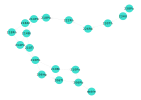

In [47]:
function display_decay_chain(ancestor)
    g, nodelabel = make_decay_chain_graph(ancestor)
    layout=(args...)->spring_layout(args...; C=3)
    return gplot(g, layout=layout, nodelabel=nodelabel, NODELABELSIZE=2.75,
                NODESIZE=.07, EDGELINEWIDTH=.1, arrowlengthfrac=0.05)
end
display_decay_chain("238Pu")

In [49]:
function add_step(decay_probabilities, decay_energies, e_fold_times,
    new_probs, new_energies, new_times)
    if length(new_probs) > 1
        push!(decay_probabilities, new_probs)
        push!(decay_energies, new_energies)
        push!(e_fold_times, new_times)
    else
        push!(decay_probabilities, new_probs[1])
        push!(decay_energies, new_energies[1])
        push!(e_fold_times, new_times[1])
        end
    return decay_probabilities, decay_energies, e_fold_times
end
function add_step(info_dict, new_step)
    decay_probs, decay_energies = info_dict["Probabilities"], info_dict["Energies (keV)"]
    e_fold_times = info_dict["e-fold (seconds)"]
    decay_probs, decay_energies, e_fold_times = add_step(decay_probs, decay_energies, 
        e_fold_times, new_step["Probabilities"], new_step["Energies (keV)"], 
        new_step["e-fold (seconds)"])   
    return Dict(["Probabilities" => decay_probs, "Energies (keV)" => 
    decay_energies, "e-fold (seconds)" => e_fold_times])
end
function add_step_no_nesting(info_dict, new_step)
    new_dict = Dict([])
    for key in keys(info_dict)
        new_dict[key] = vcat(info_dict[key], new_step[key])    
    end
    return new_dict
end

add_step_no_nesting (generic function with 1 method)

I can just traverse the decay chain using the Daughters key in the subdictionary for each Parent key :) 

So the dictionary representation in decay_chains should be sufficient!

It'll be easiest to just recurse everytime there are multiple decay modes. However, there should NEVER be a nested vector from this function. 

In [55]:
decay_chains["4H"]["Parent"]

Dict{String, Vector} with 4 entries:
  "e-fold (seconds)" => [2.06435e-22]
  "Probabilities"    => [1.0]
  "Energies (keV)"   => [2880.39]
  "Daughters"        => ["3H"]

TODO: Store the the energy by decay type (and the spectra) individually for each decay chain as a function of time. 

In [111]:
function get_power_by_isotope(isotope, ancestor)
    chain = decay_chains[ancestor]
    parent = "Parent"
    info_dict = Dict(["Probabilities" => Vector{Any}(), 
                    "Energies (keV)" => Vector{Any}(), 
                    "e-fold (seconds)" => Vector{Any}()])    
    while !( (isotope == parent)
            || (length(chain[parent]["Daughters"]) > 1) 
            || (is_last_step(chain[parent]["Daughters"])) )
        #only one decay mode
        info_dict = add_step(info_dict, chain[parent])
        parent = chain[parent]["Daughters"][1]
    end
    if !( is_last_step(chain[parent]["Daughters"])
        || isotope in chain[parent]["Daughters"] )
        #multiple decay modes
        for daughter in chain[parent]["Daughters"]
            if parent == "Parent"
                println(ancestor, " -> ", daughter)
            else
                println(parent, " -> ", daughter)
            end
            info_dict = add_step_no_nesting(info_dict, chain[parent])
            new_step = get_power_by_isotope(isotope, daughter)
            info_dict = add_step_no_nesting(info_dict, new_step)
        end
    elseif isotope in chain[parent]["Daughters"] 
        #Only include the decay of parent if it directly decays into isotope.
        isotope_index = get_index(isotope, chain[parent]["Daughters"])
        for key in keys(info_dict)
            info_dict[key] = vcat(info_dict[key], chain[parent][key][isotope_index])    
        end
        if parent == "Parent"
            println(ancestor, " -> ", isotope)
        else
            println(parent, " -> ", isotope)
        end
        #Now to include the decay of isotope
        for daughter in chain[isotope]["Daughters"]
            println(isotope , " -> ", daughter)
        end
        info_dict = add_step(info_dict, chain[isotope])
        return info_dict
    end
    return info_dict
end
dict = get_power_by_isotope("210Po", "210Pb")

210Pb -> 210Bi
210Bi -> 210Po
210Po -> 206Pb
210Pb -> 206Hg


Dict{Any, Any} with 3 entries:
  "e-fold (seconds)" => Any[1.0107e9, 1.0107e9, 624740.0, 1.72484e7, 1.0107e9, …
  "Probabilities"    => Any[1.0, 1.9e-8, 1.0, 1.0, 1.0, 1.9e-8, 1.0, 1.0]
  "Energies (keV)"   => Any[6.08, 0.0, 389.0, 5304.38, 6.08, 0.0, 400.35, 538.3…

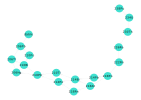

In [73]:
display_decay_chain("238Pu")

Now I will symbolically calculate the power generated by a decay chain represented as follows

In [49]:
decay_dict = Dict([])
E_0, E_1, E_2, p_0, p_1, p_2, t = @variables E_0, E_1, E_2, p_0, p_1, p_2, t
E_1b, p_1b, λ_1b = @variables E_1b, p_1b, λ_1b
decay_dict["Parent"] = Dict(["Energies (keV)" => [E_0], "e-fold (seconds)" => [λ_0], 
                            "Probabilities" => [p_0], "Daughters" => ["daughter0"]])
decay_dict["daughter0"] = Dict(["Energies (keV)" => [E_1, E_1b], 
                                "e-fold (seconds)" => [λ_1, λ_1b], 
                                "Probabilities" => [p_1, p_1b], 
                                "Daughters" => ["daughter1", "daughter1b"]])
decay_dict["daughter1"] = Dict(["Energies (keV)" => [E_2], "e-fold (seconds)" => [λ_2], 
                                "Probabilities" => [p_2], "Daughters" => ["daughter2"]])
decay_dict

Dict{Any, Any} with 3 entries:
  "daughter1" => Dict{String, Vector}("e-fold (seconds)"=>Num[λ_2], "Probabilit…
  "Parent"    => Dict{String, Vector}("e-fold (seconds)"=>Num[λ_0], "Probabilit…
  "daughter0" => Dict{String, Vector}("e-fold (seconds)"=>Num[λ_1, λ_1b], "Prob…

In [51]:
is_not_last(part) = !("stable" == part || occursin("not yet accounted for", part))
part = decay_chains["210Bi"]["206Pb"]["Daughters"][1]
part, is_not_last(part)

("stable", false)

In [52]:
function make_nested_vectors(parent)
    decay_chain = decay_chains[parent]
    info_dict = Dict(["Probabilities" => Vector{Any}(), "Energies (keV)" => 
                        Vector{Any}(), "e-fold (seconds)" => Vector{Any}()])
    for index in 1:length(decay_chain["Parent"]["Daughters"])
        daughter = decay_chain["Parent"]["Daughters"][index]
        new =  decay_chain["Parent"]
        new_info = add_step(Vector{Any}(), Vector{Any}(), Vector{Any}(),
                            new["Probabilities"][index], new["Energies (keV)"][index], 
                            new["e-fold (seconds)"][index])
        decay_probabilities, decay_energies, e_fold_times = new_info
        #include the decay of the parent isotope into this particular daughter isotope
        daughter_info_dict = Dict(["Probabilities" => decay_probabilities, "Energies (keV)" => 
                            decay_energies, "e-fold (seconds)" => e_fold_times])
        isotope = daughter
        #Go down the decay chain until it reaches an isotope with multiple decay modes
        while (length(decay_chain[isotope]["Daughters"]) == 1 && 
                is_not_last(decay_chain[isotope]["Daughters"][1]))
            granddaughter = decay_chain[isotope]["Daughters"][1]
            #now include the decay of the daughter isotope into a particular granddaughter isotope 
            daughter_info_dict = copy(add_step(copy(daughter_info_dict), 
                                            decay_chain[isotope]))
            isotope = granddaughter
        end
        #There are multiple decay modes
        if !is_last_step(decay_chain[isotope]["Daughters"])
            new = make_nested_vectors(isotope)
            #Use recursion to include multiple decay modes of the daughter isotope
            daughter_info_dict = add_step(daughter_info_dict, new)
        end
        info_dict = copy(add_step(copy(info_dict), daughter_info_dict))
    end
    return info_dict
end
info_dict = make_nested_vectors("238Pu")

Dict{String, Vector{Any}} with 3 entries:
  "e-fold (seconds)" => [Any[3.99272e9, 1.11769e13, 3.43274e12, 7.28432e10, 4.7…
  "Probabilities"    => [Any[1.0, 1.0, 1.0, 1.0, 1.0, Any[Any[0.9998, 1.0, Any[…
  "Energies (keV)"   => [Any[5486.38, 4759.43, 4664.13, 4773.38, 5489.0, Any[An…

In [53]:
info_dict["Energies (keV)"]

1-element Vector{Any}:
 Any[5486.38, 4759.43, 4664.13, 4773.38, 5489.0, Any[Any[6001.14, 224.67, Any[Any[640.02, 7686.73, Any[Any[6.08, Any[Any[389.0, 5304.38], Any[0.00617, 538.37]]], Any[0.0, 400.35, 538.37]]], Any[1.15, 1216.09, Any[Any[6.08, Any[Any[389.0, 5304.38], Any[0.00617, 538.37]]], Any[0.0, 400.35, 538.37]]]]], Any[86.67, Any[Any[6686.02, Any[Any[640.02, 7686.73, Any[Any[6.08, Any[Any[389.0, 5304.38], Any[0.00617, 538.37]]], Any[0.0, 400.35, 538.37]]], Any[1.15, 1216.09, Any[Any[6.08, Any[Any[389.0, 5304.38], Any[0.00617, 538.37]]], Any[0.0, 400.35, 538.37]]]]], Any[960.33, 7128.23, 7686.73, Any[Any[6.08, Any[Any[389.0, 5304.38], Any[0.00617, 538.37]]], Any[0.0, 400.35, 538.37]]]]]]]

In [54]:
decay_chains["206Hg"]["206Tl"]

Dict{String, Vector} with 4 entries:
  "e-fold (seconds)" => [363.732]
  "Probabilities"    => [1.0]
  "Energies (keV)"   => [538.37]
  "Daughters"        => ["206Pb"]

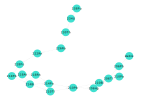

In [55]:
display_decay_chain("238Pu")

The function power per mole will calculate the power produced by a decay chain after a given time $t$ that originally starts with one mole of the parent isotope. It will use the nested vectors as seen above as an input. It also assumes there is only one decay mode for each isotope.

In [56]:
function power_per_mole(decay_probabilities, decay_energies, e_folding_times, t)
    l = length(decay_probabilities)
    if l == 1
        return decay_probabilities .* power_per_mole(r(e_folding_times, t), decay_energies[end])
    end
    output = decay_probabilities[end] * sum(power_per_mole(r(e_folding_times, t),
                                             decay_energies[end]))
    for i in 2:l
        index = l - i + 1
        output = decay_probabilities[index] * (output + 
                    power_per_mole(r(e_folding_times[1:index], t), decay_energies[index]))
    end
    return output
end

power_per_mole (generic function with 2 methods)

factor(t, e_folding_time) = 1 - exp(t / -e_folding_time)
a_prod(e_folding_times, t) = prod([factor(t, e_folding_times[k])
                                   for k in 2:length(e_folding_times)])
r(e_fold_times, t) = (a_prod(e_fold_times, t) * exp(t / -e_fold_times[1])
                                   / e_fold_times[1])

In [57]:
expected_output = (
    p_0 * (E_0 * exp(t / -λ_0) / λ_0 + 
        p_1 * ((1 - exp(t / -λ_1)) * E_1 * exp(t / -λ_0) / λ_0 + 
            p_2 * (1 - exp(t / -λ_1)) * (1 - exp(t / -λ_2)) * E_2 * exp(t / -λ_0) / λ_0
        ) + 
        p_1b * (1 - exp(t / -λ_1b)) * E_1b * exp(t / -λ_0) / λ_0
    )
)          

p_0*(p_1*((E_1*(1 - exp(t / (-λ_1)))*exp(t / (-λ_0))) / λ_0 + (E_2*p_2*(1 - exp(t / (-λ_1)))*(1 - exp(t / (-λ_2)))*exp(t / (-λ_0))) / λ_0) + (E_0*exp(t / (-λ_0))) / λ_0 + (E_1b*p_1b*(1 - exp(t / (-λ_1b)))*exp(t / (-λ_0))) / λ_0)

In [58]:
decay_probabilities = [p_0, [[p_1, p_2], [p_1b]]]
decay_energies = [E_0, [[E_1, E_2], [E_1b]]]
e_folding_times = [λ_0, [[λ_1, λ_2], [λ_1b]]]

2-element Vector{Any}:
 λ_0
    Vector{Num}[[λ_1, λ_2], [λ_1b]]

maybe instead I can split up the nested array? 

In [77]:
function process_nested_vectors(e_folding_times, decay_probabilities, 
                                decay_energies, t, is_parent)
        index = 1
        while (typeof(e_folding_times[index]) in [Float64, BigFloat, Num] 
                && index < length(e_folding_times))
                index+=1
        end
        nested_indices = index:length(e_folding_times)
        if is_parent
                if index == 2
                        power = power_per_mole(decay_probabilities[1], 
                                        decay_energies[1], 
                                        e_folding_times[1], t)
                elseif index > 2
                        sub_times = [x for x in e_folding_times[1:index-1]]       
                        power = power_per_mole(decay_probabilities[1:index-1], 
                                decay_energies[1:index-1], 
                                sub_times, t)
                end
        else
                power = 0
        end
        if typeof(e_folding_times[index]) in [Float64, BigFloat, Num]
                power = power_per_mole(decay_probabilities[1], 
                                        decay_energies[1], 
                                        e_folding_times[1], t)
        else
                for i in nested_indices 
                        for mini_index in 1:length()
                        if !(typeof(e_folding_times[i]) 
                                in [Float64, BigFloat, Num])
                                #recurse
                        else
                                relevant_indices = [x for x in vcat(collect(1:index-1), 
                                                                [i][1]]
                                relevant_times = [x for x in vcat(e_folding_times[1 : index-1], 
                                                        e_folding_times[i][1])]
                                println(decay_energies[i][1][end])
                                power += (decay_energies[i] * prod(decay_probabilities[i][1])
                                                * prod(decay_probabilities[1 : index-1]) * 
                                        r(relevant_times, t))
                        end
                        end
                end
        end
        return power
end
decay_probabilities = [p_0, [[p_1, p_2], [p_1b]]]
decay_energies = [E_0, [[E_1, E_2], [E_1b]]]
e_folding_times = [λ_0, [[λ_1, λ_2], [λ_1b]]]
process_nested_vectors(e_folding_times, decay_probabilities, 
                        decay_energies, t, true)
#r([λ_0, λ_1, λ_2], t)

Vector{Num}[[E_1, E_2], [E_1b]]


LoadError: MethodError: no method matching +(::Num, ::Vector{Vector{Num}})
[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at C:\Users\engin\AppData\Local\Programs\Julia-1.7.2\share\julia\base\operators.jl:655
[0m  +([91m::Union{InitialValues.NonspecificInitialValue, InitialValues.SpecificInitialValue{typeof(+)}}[39m, ::Any) at C:\Users\engin\.julia\packages\InitialValues\OWP8V\src\InitialValues.jl:154
[0m  +([91m::ChainRulesCore.AbstractThunk[39m, ::Any) at C:\Users\engin\.julia\packages\ChainRulesCore\C73ay\src\tangent_arithmetic.jl:122
[0m  ...

In [41]:
Test.@test Symbolics.simplify(power_per_mole(decay_probabilities,
                                decay_energies, e_folding_times, t) 
            - conversion_factor * expected_output) == 0

Test Passed
  Expression: Symbolics.simplify(power_per_mole(decay_probabilities, decay_energies, e_folding_times, t) - expected_output) == 0
   Evaluated: 0 == 0

For small nuclides, it only takes about 1 second for 100 nuclides. For large nuclides, it takes 1 minute for 100 nuclides. 

Export the comprehensive decay chains of each nuclide into a directory and store them in the Julia workspace as a dictionary. 

In [113]:
comprehensive_decay_chains_dir = cross_section_dir * "Comprehensive_decay_chains\\"
decay_dict = Dict([])
for nuclide in livechart_nuclides
    try
        decay_dict[nuclide] = make_complete_decay_chain(nuclide)
        CSV.write(comprehensive_decay_chains_dir * nuclide * ".csv", 
                    DataFrame(decay_routes = decay_dict[nuclide]))
    catch
        println(nuclide, " did not work")
    end
end
decay_dict

1Nn did not work
5He did not work
9He did not work
10He did not work
4Li did not work
5Li did not work
10Li did not work
12Li did not work
6Be did not work
7Be did not work
13Be did not work
15Be did not work
16Be did not work
7B did not work
9B did not work
16B did not work
18B did not work
20B did not work
9C did not work
10N did not work
11N did not work
24N did not work
15F did not work
28F did not work
30F did not work
33Ne did not work
18Na did not work
19Na did not work
20Na did not work
36Na did not work
20Mg did not work
39Mg did not work
21Al did not work
43Al did not work
25P did not work
26S did not work
29Cl did not work
30Cl did not work
52Cl did not work
31Ar did not work
37Ar did not work
33K did not work
34K did not work
37K did not work
56K did not work
34Ca did not work
37Ca did not work
41Ca did not work
58Ca did not work
38Sc did not work
39Sc did not work
41Sc did not work
61Sc did not work
39Ti did not work
41Ti did not work
44Ti did not work
64Ti did not work
42

Dict{Any, Any} with 2157 entries:
  "145Te" => ["145Te,B-,100%,2827.62keV, seconds,145I,B-, %,2468.0keV,0.0000004…
  "43Si"  => ["43Si,B-N, %,B-N not yet accounted for,B-N not accounted for ,B-N…
  "113Sn" => ["113Sn,EC+B+,100%,0.0keV,9943776seconds,113In,stable"]
  "106Nb" => ["106Nb,B-,100%,3313.0keV,1.02seconds,106Mo,B-,100%,1212.18keV,8.7…
  "230Pu" => ["230Pu,A,100%,7045.98keV,102seconds,226U,A,100%,7539.15keV,0.268s…
  "168Eu" => ["168Eu,B-,100%,2168.0keV,0.2seconds,168Gd,B-,100%,1521.0keV,3.03s…
  "160Dy" => ["160Dy,stable"]
  "18Ne"  => ["18Ne,EC+B+,100%,1499.16keV,1.672seconds,18F,EC+B+,100%,241.63keV…
  "75Cu"  => ["75Cu,B-,100%,2688.0keV,1.224seconds,75Zn,B-,100%,1893.42keV,10.2…
  "162Sm" => ["162Sm,B-,100%,1383.0keV,2.4seconds,162Eu,B-,100%,655.68keV,10.6s…
  "57V"   => ["57V,B-,100%,3558.89keV,0.32seconds,57Cr,B-,100%,1948.93keV,21.1s…
  "208Po" => ["208Po,A,99.996%,5114.7keV,91451971.47436762seconds,204Pb,A, %,19…
  "222Pa" => ["222Pa,A,100%,4227.89keV,0.0029seconds,218A